# Risk-Return Optimization: Implementing Markowitz Portfolio Models on Nasdaq-100
## Introduction
In the markdown we will explore a well known method of portfolio optimization - the Markowitz model. This model will later be used on stocks featured in the Nasdaq-100 index. Furthermore, we will explore some variations of this method plus compare it to the Nasdaq-100 index itself and other approaches to portfolio selection.

## Data
The interesting part of this project is in the data we use. Often, when doing this type of historical backtesting, we would select a stock exchange such as Nasdaq or an index and select all or a subset of its stocks. The main problem with this approach is selection bias. We use stocks that are still active today while the stocks of companies that defaulted, were delisted, were sold off, or became irrelevant are not represented. This certainly introduces a bias that I would argue is of a positive nature, inflating the hypothetical returns.

Thus, the data we used consist of stocks that were listed as part of the Nasdaq-100 on December 30, 2014 (https://en.wikipedia.org/w/index.php?title=Nasdaq-100&oldid=640183946). This introduces an additional challenge in obtaining our data as Yahoo Finance does not store historical prices of delisted stocks. We were able to only partially succeed, as the total number of stocks we were able to find historical data is 91. We also opted to only choose one ticker per company. The time frame we will be investing in is from the start of 2015 until the end of 2019. And the data we will use are from the beginning of 2010 onwards. Now the reason we chose this period is it's relative stability and prosperity of this period. This is very beneficial for the performance of the Markowitz model, which creates its portfolio based on historical performance of stocks, and any sudden changes in behavior connected to economical downturns would harm its performance.

In [1]:
## Importing libraries used in the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

In [2]:
## Here we have two different files which contain tickers of stocks we used. As the name suggest the first one is stocks still active and the second stocks already not present on the stock exchange
tickers_active = pd.read_csv('Nasdaq-100_active.csv', header=None, names=["Ticker"])
tickers_delisted = pd.read_csv('Nasdaq-100_delisted.csv', header=None, names=["Ticker"])
tickers = np.array(tickers_active["Ticker"].tolist() + tickers_delisted["Ticker"].tolist())
number_of_stocks = len(tickers)

In [3]:
## We download stock data (only prices which Markowitz model uses) from yahoo finance using library yfinance for active stocks. For delisted stocks we downloaded the historical data from investing.com.
stocks_prices = []
for ticker in tickers_active.Ticker:
    stock_data = yf.download(ticker, start="2010-01-01", end="2020-01-01",progress=False).Close[ticker]
    stocks_prices.append(stock_data)
    
for ticker in tickers_delisted.Ticker:
    stock_data = pd.read_csv('Stock Data/'+ticker+'.csv',index_col=0,parse_dates=['Date']).iloc[::-1].Price ## We reverse the order as we downloaded the data from newest to oldest
    stocks_prices.append(stock_data)

stocks_prices = np.array(stocks_prices,dtype=object) ## We create a numpy array we later take advantage of

In [4]:
## Here we calculate daily returns for all the stocks up to the end of 2014.
stock_returns_before2015 = []

for stock in stocks_prices:
    mask = stock.index < '2015-01-01'
    stock_before_2015 = stock[mask]
    stock_returns = stock_before_2015.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:] ## We calculate the returns using window function, we also get the first value of the output as NaN so we just omit it
    stock_returns_before2015.append(stock_returns)

Now looking at the data that was at disposal in 2015, first good thing to know is if the data we collected or gathered is full for all the stocks, because later when we want to estimate the behaviour of individual stocks and their relations we need sufficient amount of data. As we clearly see in following bar chart we have only six stocks that don't possess the full history (as the last 4 in the graph have the maximum possible). For the case of CHTR there are some gaps in the data, but it's very infrequent to have a large effect on the result thus for the simplicity we will ignore this discrepancy. In all the other cases these are stocks where the history starts after the start of 2010, but in our opinion we still possess enough of data to have reasonable estimates. These estimated might even be preferable as we will argue later.

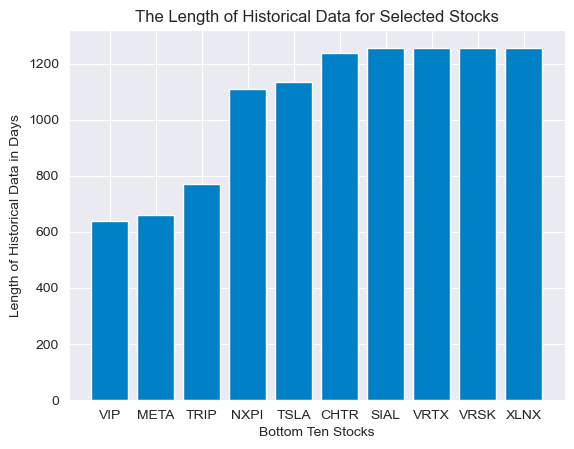

In [5]:
## Calculating the number of observations (trading days) for our stocks and ploting the result
length_of_history = []
for stock in stock_returns_before2015:
    length_of_history.append(len(stock))
length_of_history = pd.DataFrame(length_of_history,index=tickers,columns=['length'])

length_of_history = length_of_history.sort_values(by='length',ascending=True)
plt.bar(length_of_history.index[:10],length_of_history.length[:10],color='#0080C6')
plt.title('The Length of Historical Data for Selected Stocks')
plt.ylabel('Length of Historical Data in Days')
plt.xlabel('Bottom Ten Stocks')
plt.show()

Now we calculate average annual return $r$ for all the stocks from the daily average return $r_d$ using formula $r = (1 + r_d)^{251} - 1$. We use 251 as this is the standard number of trading days in a year. We will also calculate the variance of all the stocks calculated from the daily returns $x_i$ as $\frac{1}{n-1} \sum_{i=1}^n (x_i - r_d)^2$, where $n$ is the number of total trading days. We will also calculate covariance as we will use it later. The equation for the calculation of sample covariance is $\frac{1}{n-1} \sum_{i=1}^{n} (x_{i1} - r_{d1}) (x_{i2} - r_{d2})$, where the 1 and 2 signals if we use the returns of the first stock or the second stock in the calculation.

In [63]:
## Calculating the mean
annual_mean_returns = []

for stock_returns in stock_returns_before2015:  
    daily_mean_return = np.mean(stock_returns)
    annual_mean_return = (1+daily_mean_return)**251 - 1
    
    annual_mean_returns.append(annual_mean_return)
    
annual_mean_returns = np.array(annual_mean_returns) # Converting into array for easier handling

## Calculating the covariance
covariance_matrix = np.zeros((number_of_stocks,number_of_stocks))

for i,returns_1 in enumerate(stock_returns_before2015):
    set_of_dates_1 = set(returns_1.index)
    
    for j,returns_2 in enumerate(stock_returns_before2015):
        set_of_dates_2 = set(returns_2.index)
        set_of_dates = set_of_dates_1 & set_of_dates_2 ## Here we only consider dates where both stocks had returns (only effective for VIP, META, TRIP, NXPI, TSLA and CHTR)
        
        mask_1 = [date in set_of_dates for date in returns_1.index]
        mask_2 = [date in set_of_dates for date in returns_2.index]
        
        
        covariance_matrix[i,j] = np.cov(returns_1[mask_1],returns_2[mask_2])[0,1]

Now that we have the estimates we can show some interesting stocks in a plot as showing all the stocks wouldn't be very helpful as there are 91 of them. In the first plot we see the worst performing stock overall. There is not much to say about this stock, it was gradual decline of the stock's value other than the sudden drop in mid 2011. But there also was high resurgence in the end of 2015 and that might be the reason the stock was part of Nasdaq-100 in 2015 (as of 2025 the stock is no longer active).

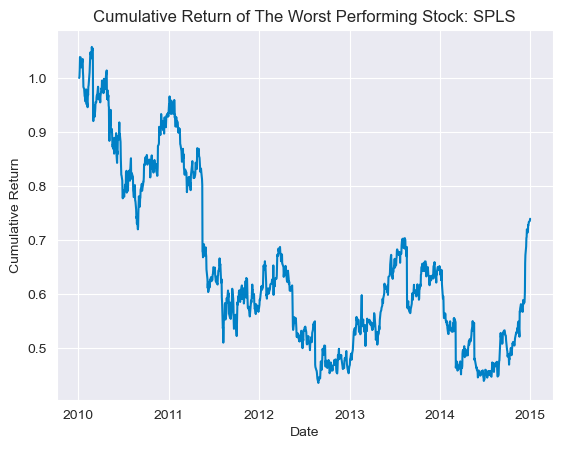

In [7]:
stocks_argsort = np.argsort(annual_mean_returns) ## Using sorting function to determine the order

plt.plot((1+stock_returns_before2015[stocks_argsort[0]]).cumprod(),color='#0080C6')
plt.title(f'Cumulative Return of The Worst Performing Stock: {tickers[stocks_argsort[0]]}')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

The second plot here it the polar opposite, the best performing stock. Here we just see very steady growth over the years brining cumulative return just under 1600 percent. This stock is still part of the Nasdaq-100 index as of 2025, even though since 2015 the cumulative gain is only under 70 percent.

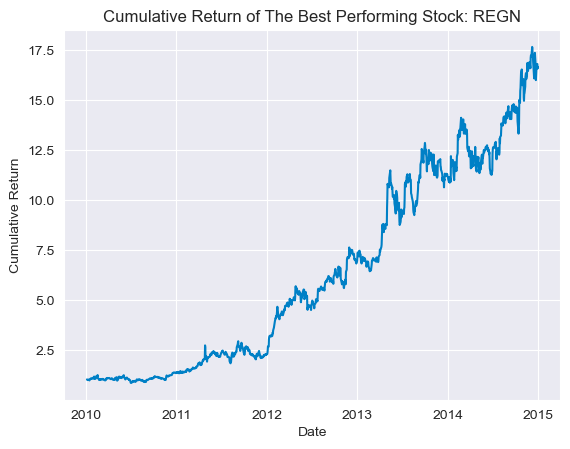

In [8]:
plt.plot((1+stock_returns_before2015[stocks_argsort[-1]]).cumprod(),color='#0080C6')
plt.title(f'Cumulative Return of The Best Performing Stock: {tickers[stocks_argsort[-1]]}')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.show()

More interesting is the following graph. Here we have stocks that were just in 25, 50 and 75 percentile of all the stocks in the estimated mean of gain. The interesting part is that each stock was at some point the best and the worst performing compared to the other two. The best of these was for the first half of the 5 years the worst of them but in mid 2012 the rise started and the stock ended with total cumulative return of 335% (about 40% annually). The 50 percentile one had performance of 134% (26% annually) and the worst of those three 114% (19% annually).

Now here we can clearly see a major discrepancy. As cumulative return for the 50 percentile stock is not the 1 plus annual return to the fifth power (the cumulative return would have to be 218%). But this is because of the way we calculate the annual return from the mean of the daily returns, compared to a different approach that would be to do a fifth root of the cumulative return (as 5 years passed). This might be another argument against the method we use, and we could later compare the results if we use this type of estimates of annual returns.

Bringing our attention back at the price development over the years we clearly see that all three stocks had lost part of its value at the beginning of 2014. This can be observed also for two previous stocks.

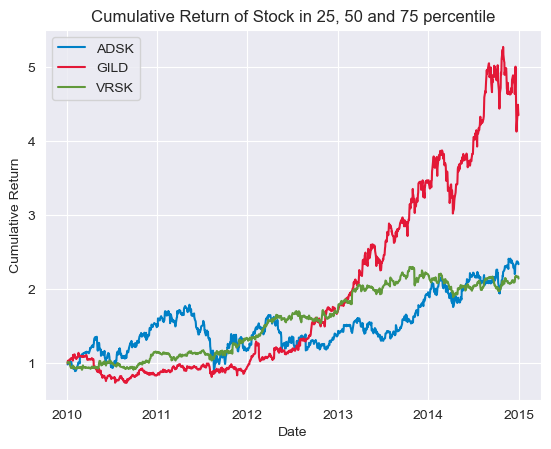

In [47]:
plt.plot((1+stock_returns_before2015[stocks_argsort[44]]).cumprod(),color='#0080C6',label=tickers[stocks_argsort[44]])
plt.plot((1+stock_returns_before2015[stocks_argsort[68]]).cumprod(),color='#E31837',label=tickers[stocks_argsort[68]])
plt.plot((1+stock_returns_before2015[stocks_argsort[23]]).cumprod(),color='#61993B',label=tickers[stocks_argsort[23]])
plt.title(f'Cumulative Return of Stock in 25, 50 and 75 percentile')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.show()

Showing all the stocks in the same graph using the above style wouldn't yield any reasonable results as the plot would be too hectic. Instead, we will focus only on the estimated means of returns. To illustrate this we are going to use a boxplot. We also want to represent all the stocks as the dots in the graph. Clearly most of the stocks are located between 0.1 and 0.5. We have a couple of stocks higher than this number, three of those are even exceeding 0.8, these are looking to be the most promising stocks. On the other hand, we have only one outlier on the opposite side of the axis, around 0. These observations clearly suggests that most of the stocks had very high returns and this signify the good condition of the economy for the observed period.

C:\Users\Martin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Martin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


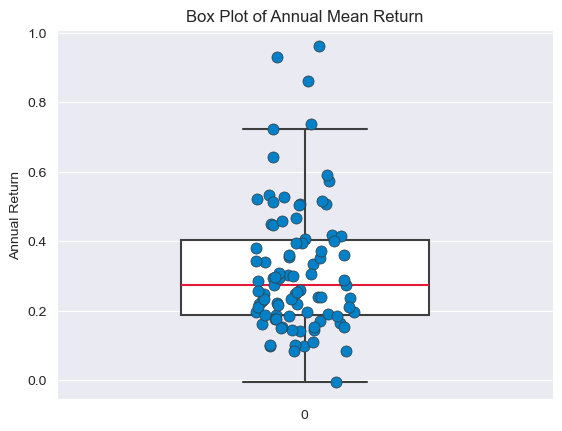

In [65]:
sns.boxplot(annual_mean_returns,boxprops={'facecolor': 'white'},medianprops={'color': '#E31837'},width=0.5,showfliers=False)
sns.stripplot(annual_mean_returns,color='#0080C6',size=8,linewidth=0.5)
plt.ylabel('Annual Return')
plt.title('Box Plot of Annual Mean Return')
plt.show()

The penultimate plot we have in the exploratory part of the project is already tightly connected to the Markowitz model as we plot the stocks respective to their annual return but also to their volatility which we calculate as a standard deviation and in the framework of Markowitz model this is the square root of the risk of the investment. The first thing we clearly observe is that certain level of risk we see that high risk means high annual return of the stock. But we fear that this might only be because of the selection bias as all these stocks are part of the Nasdaq-100 and if the stock would be highly risky but would lose most of its value as this is what we expect, those stocks would probably not be part of the index. Also for the lower values of risk (those where we suppose the selection bias is not as big) we see that as the risk increases the values of the annual return is more volatile, that is to be expected as we previously hinted. 

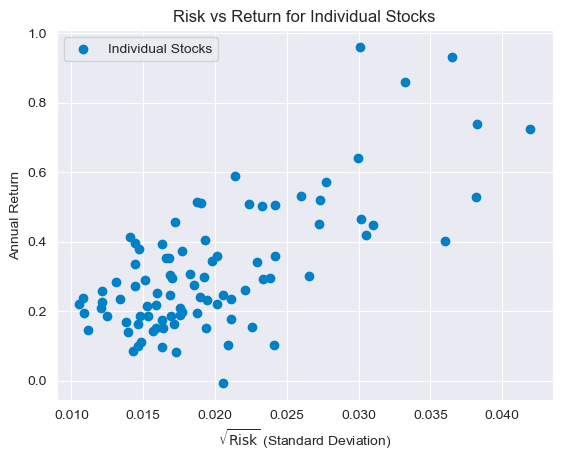

In [11]:
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')
plt.title('Risk vs Return for Individual Stocks')
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$ (Standard Deviation)')
plt.ylabel('Annual Return')
plt.show()

In the last plot, we also want to compare individual stocks to the index from which they were selected, the Nasdaq-100. A layman might assume that the index would fall somewhere in the middle in terms of both return and risk. In the plot we see that the assumption is highly inaccurate as the Nasdaq-100 looks very risk-averse while having less than average return. From an expert's perspective, this is expected, as the index is diversified product thus reducing the risk associated with volatility. The sub-average return also makes sense as some of the best performing stocks that are now (in 2015) part of the index were too small in terms of market capitalization to be included earlier. Additionally, stocks that were originally part of the index in 2010 but underperformed may have been removed over time. As a result, the composite index performed slightly worse than the individual stocks currently in it.

In [12]:
nasdaq_100_before_2015 = yf.download('^NDX', start="2010-01-01", end="2015-01-01",progress=False).Close['^NDX']
nasdaq_100_before_2015_returns = nasdaq_100_before_2015.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]
nasdaq_100_mean = ((1+np.mean(nasdaq_100_before_2015_returns))**251-1)
nasdaq_100_variance = np.var(nasdaq_100_before_2015_returns)

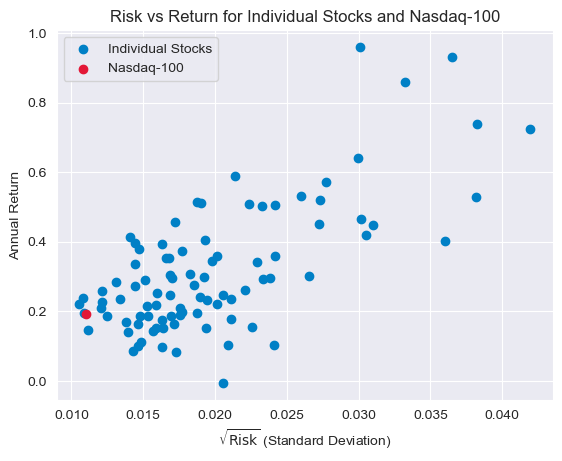

In [13]:
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')
plt.scatter(np.sqrt(nasdaq_100_variance),nasdaq_100_mean,color='#E31837',label='Nasdaq-100')
plt.title('Risk vs Return for Individual Stocks and Nasdaq-100')
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$ (Standard Deviation)')
plt.ylabel('Annual Return')
plt.show()

## Markowitz model

The Markowitz approach is to construct the portfolio based on two apparent but contradictory targets. We want a portfolio with as high a return as possible. But on the other hand, we also desire a portfolio that is not risky - thus, we want to minimize risk. To solve this problem of contradictory targets, we select either minimal return we accept or maximal risk we wish to undergo. From this, we construct two optimization problems. The first and more common is as follows

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& 1^T x = 1 \\
    & r^T x = \mu,
\end{align}
$$

where $x$ is the vector of positions we hold in different stocks, where positive value indicates long position and negative value short position. The so-called objective function, which we want to minimize, is half the risk of the portfolio, where $V$ is the covariance matrix. The first condition means that the sum of the weights is one, as we want to invest 100% of our investment, where short positions generate additional funds at the start at no additional cost. This is unrealistic, as it also ignores the spread that between buying and selling the stock, but it is commonly used in theory. The second condition represents our desire to have an annual return on our investment as $\mu$, this annual return is expected return.

To solve this problem, we will use Lagrange function in the following form:

$$
\begin{align}
    L(x,\delta_1,\delta_2) = \frac{1}{2} x^T V x + \delta_1 (1 - 1^T x) + \delta_2 (\mu - r^T x)
\end{align}
$$

We are going to calculate the derivative of this function with respect to $x$, set to zero, and derive the solution.

$$
\begin{align}
    \frac{d}{dx} L(x,\delta_1,\delta_2) = V x - \delta_1 1 - \delta_2 r &= 0 \\
    x &= V^{-1} (\delta_1 1 + \delta_2 r)
\end{align}
$$

Using the first condition and the derived formula for $x$, we get $\delta_1$:

$$
\begin{align}
    1^T x &= 1 \\
    1^T V^{-1} (\delta_1 1 + \delta_2 r) &= 1 \\
    \delta_1 1^T V^{-1} 1 +  \delta_2 1^T V^{-1} r &= 1 \\
    \delta_1 &= \frac{1-\delta_2 1^T V^{-1} r}{1^T V^{-1} 1}
\end{align}
$$

Furthermore, we will improve the clarity of our equations by introducing often used notations that put $A = 1^T V^{-1} 1$, $B = 1^T V^{-1} r$, $C = r^T V^{-1} r$ and $\Delta = AC - B^2$ (keep in mind that these are all scalar numbers). Using this, we have that $\delta_1 = \frac{1-\delta_2 B}{A}$. Continuing on we make use of the second condition and the formulae for $x$ and $\delta_1$ to finally derive $\delta_2$.

$$
\begin{align}
    r^T x &= \mu \\
    r^T V^{-1} (\delta_1 1 + \delta_2 r) &= \mu \\
    \delta_1 B + \delta_2 C &= \mu \\
    \frac{1-\delta_2 B}{A} B + \delta_2 C &= \mu \\
    B - \delta_2 B^2 + \delta_2 C A &= A \mu \\
    \delta_2 &= \frac{A \mu - B}{AC - B^2} \\
    \delta_2 &= \frac{A \mu - B}{\Delta}
\end{align}
$$

Now, inserting this result back to the formula for $\delta_1$, we get

$$
\begin{align}
    \delta_1 &= \frac{1-\delta_2 B}{A} \\
    \delta_1 &= \frac{1-\frac{A \mu - B}{\Delta} B}{A} \\
    \delta_1 &= \frac{AC - B^2 -AB \mu + B^2}{A \Delta} \\
    \delta_1 &= \frac{C - B \mu}{\Delta}
\end{align}
$$

This is the final result we will use to calculate the Markowitz portfolio for different values of expected returns. The notation we introduced is also beneficial, as we don't have to calculate it every time, it's sufficient to calculate it once for each date and collection of stocks. We will calculate all the Markowitz portfolios for expected returns from -0.5 to 1.5.

In [15]:
inverse_covariance_matrix = np.linalg.inv(covariance_matrix) ## Inverting the covariance matrix V

## Calculating the parts of the Markowitz formula which don't change (as we change expected return)
A = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ np.ones(number_of_stocks)
B = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ annual_mean_returns
C = annual_mean_returns.T @ inverse_covariance_matrix @ annual_mean_returns
D = A*C - B**2

In [16]:
expected_returns = np.linspace(-0.5, 1.5, 201) ## We want mu between -0.5 and 1.5

## We calculate weights and then risk for given expected returns.
markowitz_portfolios = []

for expected_return in expected_returns:
    delta_1 = (C - B * expected_return) / D
    delta_2 = (A * expected_return - B) / D
    x = inverse_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_mean_returns)
    ## Here we get weights but to plot the various portfolios we want to get the sqrt of risk and the expected return
    markowitz_portfolios.append((np.sqrt(x.T @ covariance_matrix @ x), x.T @ annual_mean_returns))

Not all portfolios created by Markowitz model are so-called efficient portfolios, and thus part of the Efficient Frontier. Because all the results the model creates are on some sort of parabola as we see in the following graph, only one half of the parabola is the efficient frontier. What is clearly visible in the plot is that if we have correctly estimated the behaviour and the relationships of the stocks, we can create a portfolio that is much less risky, while being as profitable as investing in one individual stock.

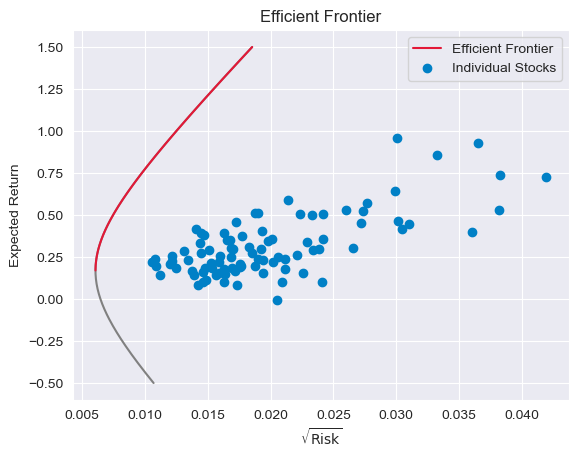

In [17]:
## Ploting the Efficient Frontier together with the individual stocks

markowitz_portfolios = pd.DataFrame(markowitz_portfolios,columns=['Risk','Return'])
plt.plot(markowitz_portfolios.Risk,markowitz_portfolios.Return,color='gray') ## Plotting all the Markowitz portfolios

efficient_frontier = markowitz_portfolios.iloc[np.argmin(markowitz_portfolios.Risk):] ## Restricting only for efficient portfolios
plt.plot(efficient_frontier.Risk,efficient_frontier.Return,color='#E31837',label='Efficient Frontier')

plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

plt.legend()
plt.title('Efficient Frontier')
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.show()

We can extend the possible portfolios by also considering to either not invest part of the money or invest in a risk-free asset. The risk-free asset is an asset that has no probability of a negative return on the investment while having some probability of a positive return. We will not introduce this risk-free asset now, as we could argue that there is none. But the code is prepared to tackle this challenge easily. For now, we assume that the only safe investment is keeping the money on your bank account (or in your vault) and set $r_0 = 0$.

This changes the set of efficient portfolios significantly, as we introduce an asset with no return but also no risk. We see in the previous plot that the Markowitz portfolio with a 0 return still has a significant risk. So, we need significantly alter the results. We start by restating the optimization problem with $x_0$, as the portion of money we don't invest (or invest in the risk-free asset if there is any).

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& 1^T x + x_0 = 1 \\
    & r^T x + r_0 x_0 = \mu
\end{align}
$$

We can single out the $x_0$ from the first condition to put into the second condition to get the following form of the problem

$$
\begin{align}
    \min \quad& \frac{1}{2} x^T V x \\
    \text{subject to} \quad& (r - r_0 1)^T x = \mu - r_0
\end{align}
$$

This is still within the framework of Markowitz model. To solving this we again use the Langrage function.

$$
\begin{align}
    L(x,\delta) &= \frac{1}{2} x^T V x - \delta (\mu - r_0 - (r - r_0 1)^T x) \\
\end{align}
$$

$$
\begin{align}
    \frac{d}{dx} L(x,\delta) = V x + \delta (r-r_0 1) &= 0 \\
    x &= - V^{-1} \delta (r-r_0 1)
\end{align}
$$

Now, we use the equivalence in the condition to get the formula for $\delta$.

$$
\begin{align}
    (r - r_0 1)^T x &= \mu - r_0 \\
    - \delta (r - r_0 1)^T V^{-1} (r-r_0 1) &= \mu - r_0 \\
    \delta &= - \frac{\mu - r_0}{(r - r_0 1)^T V^{-1} (r-r_0 1)}
\end{align}
$$

Inputting this $\delta$ back into the formula for $x$, we get

$$
\begin{align}
    x = \frac{(\mu - r_0) V^{-1} (r-r_0 1)}{(r - r_0 1)^T V^{-1} (r-r_0 1)}
\end{align}
$$

Now, using the previously introduced notation, we have

$$
\begin{align}
    x = \frac{(\mu - r_0) V^{-1} (r-r_0 1)}{C - 2Br_0 - A r_0^2} = \frac{(\mu - r_0) (B-Ar_0)}{C - 2Br_0 - A r_0^2} \frac{V^{-1} (r-r_0 1)}{B-Ar_0}
\end{align}
$$

where, in the last equality we just multiplied the numerators and denominators by $B-Ar_0$. We did that in order to get to something called the tangency portfolio, which is the last fraction in the equation. We denote $x_T = \frac{V^{-1} (r-r_0 1)}{B-Ar_0}$. This is the only portfolio that is both the part of efficient frontier for the Markowitz model with and without risk-free asset.

Additionally, all the efficient portfolios for the model with the risk-free asset are on the line that connects tangency portfolio and portfolio where we only invest in the risk-free asset. This line is known as the Capital Market Line. There exists a handy formula to find a portfolio that has predetermined risk. We denote this risk as $\sigma^2$, also we need the risk of the tangency portfolio as $\sigma^T = x_T^T V x_T$ and the expected mean as $\mu_T = r^T x_T$. Portfolio with this risk has the following expected mean

$$
\begin{align}
    \mu = r_0 + \frac{\sigma}{\sigma_T} (\mu_T - r_0)
\end{align}
$$

and by inserting this into the previous formula, we can get the weights.


In [18]:
## Calculating the annual risk-free interest and then tangency portfolio
risk_free_interets = 0 
tangency_portfolio_weights = (inverse_covariance_matrix @ (annual_mean_returns-risk_free_interets))/(B-risk_free_interets*A)
tangency_porfolio_mean = tangency_portfolio_weights.T @ annual_mean_returns
tangency_porfolio_variance = tangency_portfolio_weights.T @ covariance_matrix @ tangency_portfolio_weights

In [19]:
## Calculating the capital market line using formula
deviations = np.linspace(0, 0.02, 201)
capital_market_line = []
for deviation in deviations:
    mean = risk_free_interets + deviation/np.sqrt(tangency_porfolio_variance) * (tangency_porfolio_mean-risk_free_interets)
    capital_market_line.append((deviation,mean))

The plot below shows the capital market line. As we previously commented, for each value of expected return we find a portfolio with a risk-free asset that is less risky than any portfolio with the same return without using a risk-free asset. The only exception is the tangency portfolio, which sits at the interception of those two lines. But clearly, the capital market line is rather close to the efficient frontier from the expected return of 0.8 onwards. What is also interesting, is how high a return the tangency portfolio expects compared to any of the individual stocks. We might want to really take a look at that in our backtesting.

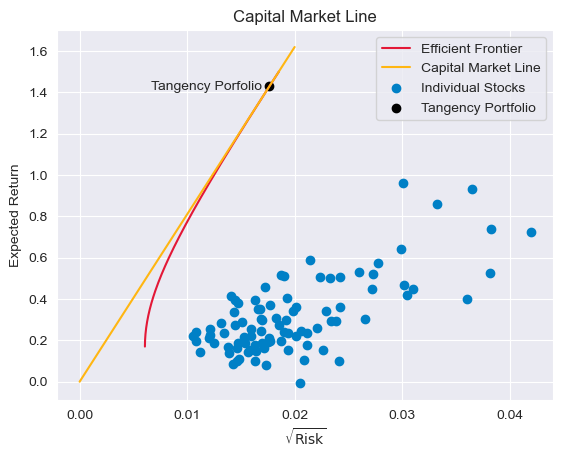

In [20]:
cml = pd.DataFrame(capital_market_line, columns=['Risk', 'Return'])

## Ploting the capital market line
plt.plot(efficient_frontier.Risk, efficient_frontier.Return, color='#E31837', label='Efficient Frontier')
plt.plot(cml.Risk, cml.Return, color='#FFB612', label='Capital Market Line')

## Ploting individual stocks
plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

## Ploting tangency portfolio
plt.scatter(np.sqrt(tangency_porfolio_variance), tangency_porfolio_mean, color='black', label='Tangency Portfolio')
plt.annotate('Tangency Porfolio', (np.sqrt(tangency_porfolio_variance), tangency_porfolio_mean),
             textcoords="offset points", xytext=(-45, -2.5), ha='center')

plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.legend()
plt.title('Capital Market Line')
plt.show()

Turning our focus back to the case with no risk-free asset we are owing the option where we have set the maximal risk $\sigma^2$ we want to endure and want the maximum available return want. Let's formulate this optimization problem.

$$
\begin{align}
    \max \quad& r^T x \\
    \text{subject to} \quad& 1^T x = 1 \\
    & \frac{1}{2} x^T V x = \frac{\sigma^2}{2}
\end{align}
$$

The Langrange function is as follows

$$
\begin{align}
    L(x,\lambda_1,\lambda_2) = r^T x - \lambda_1 (1-1^T x) + \lambda_2 (\frac{\sigma^2}{2} - \frac{1}{2} x^T V x)
\end{align}
$$

We are going calculate the derivative of this function with respect to $x$ and set it to zero.

$$
\begin{align}
    \frac{d}{dx} L(x,\lambda_1,\lambda_2) = r + \lambda_1 1 - \lambda_2 V x &= 0 \\
    x &= V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1)
\end{align}
$$

We take the first condition and insert the formula of $x$ into it.

$$
\begin{align}
    1^T x &= 1 \\
    1^T V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1) &= 1 \\
    B - \lambda_1 A &= \lambda_2 \\
    \lambda_1 &= \frac{B-\lambda_2}{A}
\end{align}
$$

Next we use the second condition and our formulae for $x$ and $\lambda_1$.

$$
\begin{align}
    \frac{1}{2} x^T V x &= \frac{\sigma^2}{2} \\
    \frac{1}{2} (r-\lambda_1 1)^T \frac{1}{\lambda_2} V^{-1} V V^{-1} \frac{1}{\lambda_2} (r-\lambda_1 1) &= \frac{\sigma^2}{2} \\
    (r-\lambda_1 1)^T V^{-1} (r-\lambda_1 1) &= \lambda_2^2 \sigma^2 \\
    C - 2 \lambda_1 B + \lambda_1^2 A &= \lambda_2^2 \sigma^2 \\
    C - 2 \frac{B-\lambda_2}{A} B + (\frac{B-\lambda_2}{A})^2 A &= \lambda_2^2 \sigma^2 \\
    AC - 2 B^2 + 2 \lambda_2 B + B^2 - 2 \lambda_2 B + \lambda_2^2 &= \lambda_2^2 A \sigma^2 \\
    AC - B^2 &= \lambda_2^2 A \sigma^2 - \lambda_2^2 \\
    \Delta &= \lambda_2^2 (A \sigma^2 - 1) \\
    \lambda_2^2 &= \frac{\Delta}{A \sigma^2 - 1} \\
    \lambda_2 &= \pm \sqrt{\frac{\Delta}{A \sigma^2 - 1}}
\end{align}
$$

We see that we derived two possible values for $\lambda_2$ this makes sense as the shape of all possible Markowitz portfolios is a parabola. To get the one on the efficient border we select the positive $\lambda_2$. Also from the square root we see that for some values of $\sigma^2$ cannot get a result. Thus, the minimal risk portfolio is the one were $A \sigma^2 - 1 = 0$ which corresponds to $\sigma^2 = \frac{1}{A}$. This portfolio then has the expected return of $\frac{B}{A}$.

In [21]:
##tickers
risks = np.linspace(np.min(efficient_frontier.Risk)**2, np.max(efficient_frontier.Risk)**2, 500) ## We want risk to be the same as it was for the efficient frontier where we fixed the return (to end up with the same plot).

## We calculate weights and then risk for given expected returns.
markowitz_portfolios_risk = []

for risk in risks:
    lambda_2 = np.sqrt(D/(A*risk-1))
    lambda_1 = (B-lambda_2)/A
    x = inverse_covariance_matrix @ (annual_mean_returns - lambda_1 * np.ones(number_of_stocks)) * (1/lambda_2)
    markowitz_portfolios_risk.append((np.sqrt(x.T @ covariance_matrix @ x), x.T @ annual_mean_returns))

The following plot is just a reassurance we constructed the same efficient frontier and we did before.

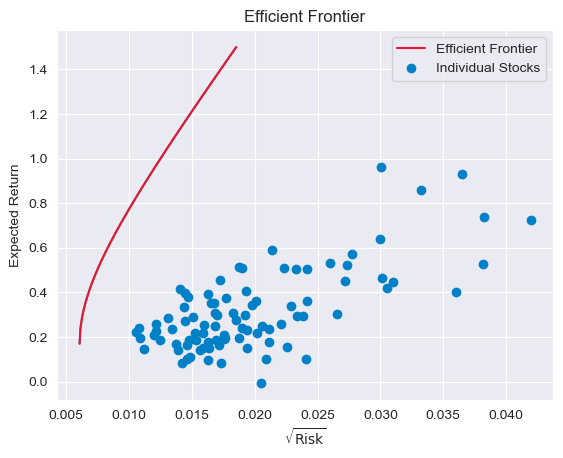

In [22]:
## Ploting the Efficient Frontier together with the individual stocks
markowitz_portfolios_risk = pd.DataFrame(markowitz_portfolios_risk, columns=['Risk', 'Return'])
plt.plot(markowitz_portfolios_risk.Risk, markowitz_portfolios_risk.Return, color='gray')

efficient_frontier_risk = markowitz_portfolios_risk.iloc[
                          np.argmin(markowitz_portfolios_risk.Risk):]  ## Restricting only for efficient portfolios
plt.plot(efficient_frontier_risk.Risk, efficient_frontier_risk.Return, color='#E31837', label='Efficient Frontier')

plt.scatter(np.sqrt(np.diag(covariance_matrix)), annual_mean_returns, color='#0080C6', label='Individual Stocks')

plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.show()

## Backtesting

In the last part we are going to observe the results of the applied theory. We are going to perform several different experiments and compare them to each other. The metric used is simply the amount of wealth at the end of the period, given that we invested a given sum of money, e.g. $100 at the beginning. A secondary metric is going to be risk, as a rational investor would pick less risky asset with the same given return.

The first experiment is going to be a regular one. We are going to use the weights for a portfolio with a predetermined wanted return, which is set at 25%. We also want to invest all out money, thus not using the risk-free asset. Denote this portfolio as $M_{25}$.

In [501]:
## Calculating the weights using previously derived formulae
wanted_return = 0.25
delta_1 = (C - B * wanted_return) / D
delta_2 = (A * wanted_return - B) / D
mu25_weights = inverse_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_mean_returns)

## We put the weights into a data frame and then sort them by the magnitude of the position (long or short)
stocks_weights = pd.DataFrame({'Stock':tickers,'Weight':mu25_weights})
stocks_weights['Long or Short'] = np.sign(stocks_weights.Weight)
stocks_weights['Absolute Weight'] = np.abs(stocks_weights.Weight)
stocks_weights['Return'] = annual_mean_returns
stocks_weights['Risk'] = np.diag(covariance_matrix)
stocks_weights.sort_values(by='Absolute Weight', ascending=False, inplace=True)

The resulting weights are mix of long and short positions. There are 52 long positions and 39 short. In the following plot we can see the top 10 positions in this portfolio. As we see only 3 stock have a weight over 10%, all of them in long position, moreover there are only 2 stocks in top 10 with short position.

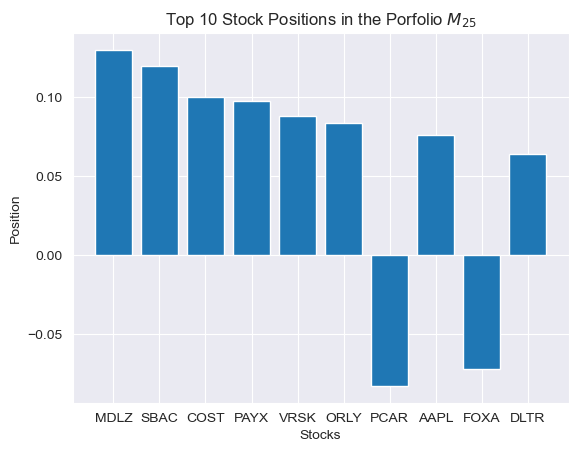

In [502]:
## Simple bar plot
plt.bar(stocks_weights.Stock[:10],stocks_weights.Weight[:10])
plt.xlabel(r'Stocks')
plt.ylabel('Position')
plt.title('Top 10 Stock Positions in the Porfolio $M_{25}$')
plt.show()

In the following plot we once again look at the positions of the constructed portfolio, but now we also see the estimated return and risk of the stocks together with the relative size and sign of the position. We got rather interesting observations. We see that most of the portfolio is composed of a low risky long positions and more risk short positions. Plus as the risk increases the size of the positions decreases. As the structure of relationships between stocks in not shown, we cannot make any concrete claims as well as comment on some strange behaviour as having a short position in the most profitable asset.

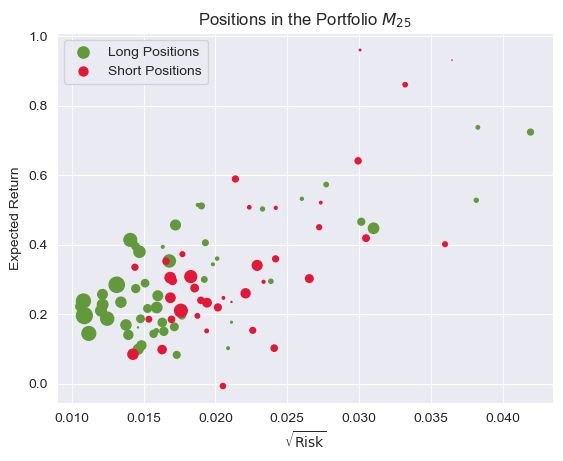

In [503]:
plt.scatter(
    np.sqrt(stocks_weights.Risk[stocks_weights['Long or Short']==1]),
    stocks_weights.Return[stocks_weights['Long or Short']==1],
    s=1000*stocks_weights.Weight[stocks_weights['Long or Short']==1],
    color='#61993B', label='Long Positions'
)
plt.scatter(
    np.sqrt(stocks_weights.Risk[stocks_weights['Long or Short']==-1]),
    stocks_weights.Return[stocks_weights['Long or Short']==-1]
    ,s=-1000*stocks_weights.Weight[stocks_weights['Long or Short']==-1]
    , color='#E31837', label='Short Positions'
)
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.title('Positions in the Portfolio $M_{25}$')
plt.show()

Now, before we see the results of the portfolio we have to define some portfolios we want compare the $M_{25}$ to. The first one is simple portfolio where we invest the same amount to each an every ticker, denoted as $EW$. Second one is the previously mentioned tangency portfolio, we calculated in the theory part, denoted as $TP$. And the last one is the index Nasdaq-100 itself. The index over time takes some stocks in and some stocks and changes the weights overtime. So, it's not a fair comparison, but it is a very important one as the only real life example and over the years it became the golden rule for an index to invest in as well as some sort of economical indicator. Let's denote is as $NDX$.

In [150]:
EW_weights = np.ones(number_of_stocks)/number_of_stocks #Equal weights portfolio
TP_weights = tangency_portfolio_weights #Tangency portfolio weights

In [151]:
## We put the weights into a data frame and then sort them by the magnitude of the position (long or short), this time for tangency portfolio
stocks_weights_TP = pd.DataFrame({'Stock':tickers,'Weight':TP_weights})
stocks_weights_TP['Long or Short'] = np.sign(stocks_weights_TP.Weight)
stocks_weights_TP['Absolute Weight'] = np.abs(stocks_weights_TP.Weight)
stocks_weights_TP['Return'] = annual_mean_returns
stocks_weights_TP['Risk'] = np.diag(covariance_matrix)
stocks_weights_TP.sort_values(by='Absolute Weight', ascending=False, inplace=True)

Firstly, let us also review the tangency portfolio $TP$. As per previous observations the portfolio is claimed to have below average risk but be immensely profitable with annual return of over 140%, better than any of the individual stocks. In the following plot it is obvious how the portfolio was constructed. We have much bigger both long and short positions, additionaly we aways chose the more profitable stocks to be in the long positions in all levels of risk. Interestingly, we still have bigger positions in stocks with lower risk. This position is very much exploiting the estimated covariance matrix to it's limits to get to the lowest risk possible. In practice I recon this porfolio is going to be either much more risky or much less profitable than we expect or both.

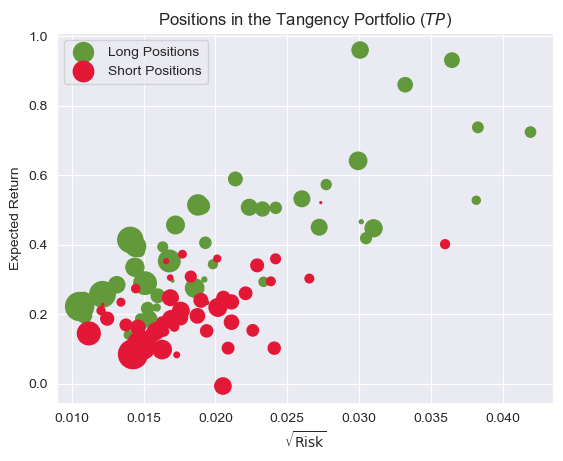

In [155]:
plt.scatter(
    np.sqrt(stocks_weights_TP.Risk[stocks_weights_TP['Long or Short']==1]),
    stocks_weights_TP.Return[stocks_weights_TP['Long or Short']==1],
    s=1000*stocks_weights_TP.Weight[stocks_weights_TP['Long or Short']==1],
    color='#61993B', label='Long Positions'
)
plt.scatter(
    np.sqrt(stocks_weights_TP.Risk[stocks_weights_TP['Long or Short']==-1]),
    stocks_weights_TP.Return[stocks_weights_TP['Long or Short']==-1]
    ,s=-1000*stocks_weights_TP.Weight[stocks_weights_TP['Long or Short']==-1]
    , color='#E31837', label='Short Positions'
)
plt.legend()
plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Expected Return')
plt.title('Positions in the Tangency Portfolio ($TP$)')
plt.show()

Here we just calculate the returns for the investing period.

In [127]:
mask = stock.index >= '2014-12-31' # Returns are one shorter
dates = list(set(stock[mask].index))
dates.sort()

In [133]:
prices = pd.DataFrame(index=dates[1:]) 
returns = pd.DataFrame(index=dates[1:]) 
for i,ticker in enumerate(tickers):
    stock = stocks_prices[i]
    stock = stock.reindex(dates).ffill()
    prices[ticker] = stock
    returns[ticker] = stock.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]

In [156]:
## Also downloading the Nasdaq 100.
nasdaq_100 = yf.download('^NDX', start="2015-01-01", end="2020-01-01",progress=False).Close['^NDX']
nasdaq_100 = nasdaq_100.reindex(dates).ffill()
nasdaq_100_returns = nasdaq_100.rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]

In this plot, we can finally see the performance of the created portfolios and the Nasdaq-100 over time. The first thing we observe is that all the portfolios ended with a positive gain. This aligns with our initial comment about the economic uplift throughout the decade. According to the metric we picked, the best performing portfolio is the tangency portfolio ($TP$). But let's comment os this further, since it was not always the best performing over the years. It had major advantage mainly between 2015 and 2016 and also after 2019 but there was a serious dip in the first half of 2019 as well. On the other hand there were times when it was the worst performing portfolio, see the end of 2016 and middle of 2017. This suggest this portfolio is highly unstable. The estimated annual mean return of $TP$ is over 27% and total return of 150%. This is extremely below the expected return given by the Markowitz model. The index Nasdaq-100 was the second-best performing with annual return of over 17% and total of 106%. The index was very similar to $EW$ portfolio at the beginning of the investment period but over time it outperformed the portfolio. The $EW$ then ended third and by a slim margin outperformed the $M_{25}$ portfolio. It had estimated annual mean return of 13.9% and total return of almost 82%.

The $M_{25}$ portfolio was the worst performing over the years, with the annual return of 13.3% and total of 80% beaten also by $EW$ which is basically just an average stock asset. And even thought you could argue that this portfolio was second best performing just 4 months before the end we clearly see from the graph that it was also the worst performing from middle of 2017 till the end of 2018. On the other hand for the first two years it was performing extremely great for some time also being the best portfolio. On the other hand this portfolio looks to be the least volatile of them all. Interestingly, also this portfolio was expected to be worse than $EW$ portfolio which was expected to have around 31% of annual gain. Later we compare our expectation and the reality, but so far it seems as the constructed portfolios don't deliver the wanted gains.

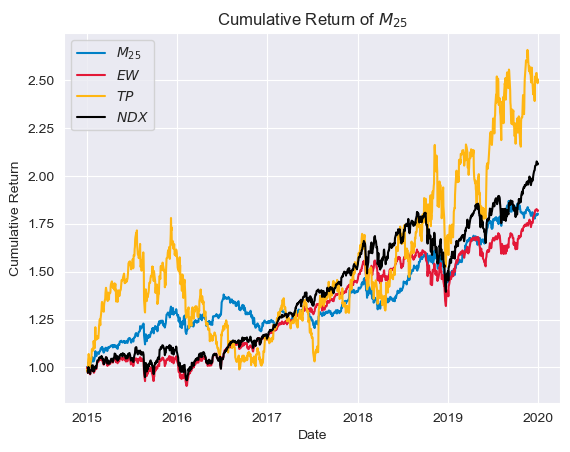

In [188]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + returns @ EW_weights).cumprod(),color='#E31837',label='$EW$')
plt.plot((1 + returns @ TP_weights).cumprod(),color='#FFB612',label='$TP$')
plt.plot((1+nasdaq_100_returns).cumprod(),color='black',label='$NDX$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $M_{25}$')
plt.show()

We add another portfolio to the mix. Let's add portfolio which has the associated risk equal to the risk of the least risky stock. Let's denote it as $\sigma_{MIN}$.

In [202]:
wanted_risk = np.min(np.diag(covariance_matrix))
beta = np.sqrt((A*wanted_risk-1)/D)
alpha = (beta * B - 1)/(beta*A)

L_1,L_2 = alpha, 1/beta
sigma_min_weights = inverse_covariance_matrix @ (annual_mean_returns - L_1 * np.ones(number_of_stocks)) * (1/L_2)

The plot for the cumulative return of the $\sigma_{MIN}$ portfolio below, places this portfolio as the second best beating $NDX$. The estimated annual return is almost 20% with the total return of 122%. We can clearly see that it is very closely connected to the tangency portfolio ($TP$). The problem here is that is it also very volatile.

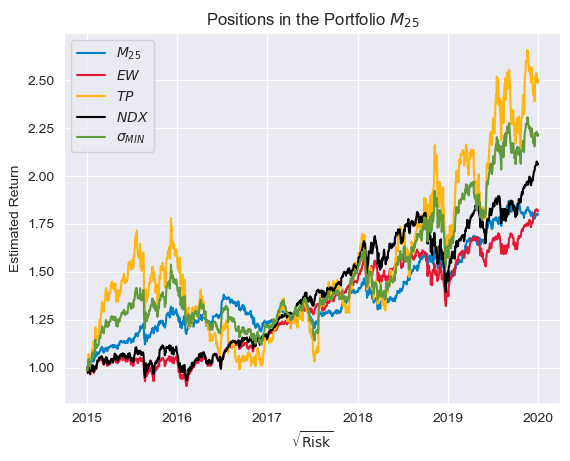

In [243]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + returns @ EW_weights).cumprod(),color='#E31837',label='$EW$')
plt.plot((1 + returns @ TP_weights).cumprod(),color='#FFB612',label='$TP$')
plt.plot((1+nasdaq_100_returns).cumprod(),color='black',label='$NDX$')
plt.plot((1 + returns @ sigma_min_weights).cumprod(),color='#61993B',label='$\sigma_{MIN}$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $\sigma_{MIN}$')
plt.show()

Now, we would like to compare the expectation we had because of the Markowitz model for return and risk to the reality. Firstly we have to calculate both the expectation and then the reality.

In [213]:
## Putting all the returns into one list
dict_of_returns = {
    '$M_{25}$':returns @ mu25_weights,
    '$EW$' : returns @ EW_weights,
    '$TP$':returns @ TP_weights,
    '$NDX$': nasdaq_100_returns,
    '$\sigma_{MIN}$': returns @ sigma_min_weights
}

In [214]:
## Calculating the expected risk and return from the formulas.
dict_of_expected_return_and_risk = {
    '$M_{25}$':(np.sqrt(mu25_weights.T @ covariance_matrix @ mu25_weights),mu25_weights.T @ annual_mean_returns),
    '$EW$' : (np.sqrt(EW_weights.T @ covariance_matrix @ EW_weights),EW_weights.T @ annual_mean_returns),
    '$TP$':(np.sqrt(tangency_porfolio_variance),tangency_porfolio_mean), ## We already calculated it earlier.
    '$NDX$': (np.sqrt(nasdaq_100_variance),nasdaq_100_mean),
    '$\sigma_{MIN}$': (np.sqrt(sigma_min_weights.T @ covariance_matrix @ sigma_min_weights),sigma_min_weights.T @ annual_mean_returns)
}
## Just color selection
portfolio_colors = {
    '$M_{25}$':'#0080C6',
    '$EW$':'#E31837',
    '$TP$':'#FFB612',
    '$NDX$':'black',
    '$\sigma_{MIN}$':'#61993B',
}

In the plot we see all the individual stocks on the axis of return and risk. Additionally, we also included all the portfolios and the index, but for each there are two dots, one showing the expectation (for the index $NDX$ it was historical return and risk) and then the arrow pointing to our estimations of reality. If we compared this to the "Risk vs Return for Individual Stocks" graph we clearly see that the individual stocks are much less profitable now. This is of course the result of selection bias we were talking about earlier. Still we see that the more risk the more potential return we can have. On the other hand there is also higher potential of low or even negative return. We can basically see a cone there starting around $\sqrt{\text{Risk}}$ of 0.01 and ending around 0.03. In the previous graph there were few of stocks that had high return and risk around 0.4. These are not present here as all the stocks in the index Nasdaq-100 were established stocks so there wasn't high chance of some sudden climb as it is possible with some less known stocks. This can be also monitored in the move of $EW$, which is just an average of all stocks. This is the only created portfolio that had lower risk than expected, this goes hand in hand with what was said above.

Looking at all the portfolios created by the Markowitz model we see that we were significantly behind the expected return, on the other hand the risk of the portfolio was not that much higher than expected, this might be rather surprising for $TP$ as it seamed to be highly volatile. It was, but it wasn't much more than expected. But what is immensely disappointing is that clearly these portfolios were not efficient as we can easily find a stock that is less risky and more profitable. There are not that many positives of the Markowitz model so far as it didn't deliver any of the expectations. The sole positive I can find is that regarding the position of the created portfolios in the hypothetical cone we previously mentioned, these portfolios seem to be at the middle and maybe slightly to the positive direction for the return axis, though this is only a sole observation as is nothing concrete.

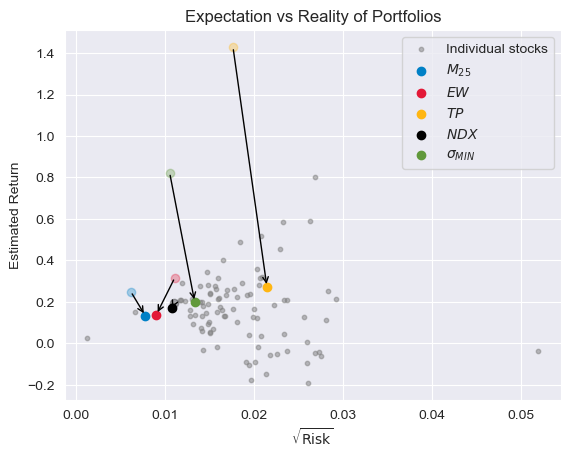

In [247]:
## Here we only calculate the individual stocks for the periods where the ticker was active
for ticker in tickers:
    ticker_returns = returns[returns[ticker]!=0][ticker]
    if ticker == "GOOG":
        plt.scatter(np.std(ticker_returns),(1+np.mean(ticker_returns)) ** 251 - 1, color='gray',s=10,alpha=0.5,label='Individual stocks') ## To only see the label once in the legend
    else:
        plt.scatter(np.std(ticker_returns),(1+np.mean(ticker_returns)) ** 251 - 1, color='gray',s=10,alpha=0.5)

for key, value in dict_of_returns.items():
    plt.scatter(np.std(value), (1+np.mean(value))**251 - 1, label=key,color=portfolio_colors[key])
    plt.scatter(dict_of_expected_return_and_risk[key][0], dict_of_expected_return_and_risk[key][1], color=portfolio_colors[key],alpha=0.3)
    plt.annotate('',xy=(np.std(value), (1+np.mean(value))**251 - 1),xytext=(dict_of_expected_return_and_risk[key][0], dict_of_expected_return_and_risk[key][1]),arrowprops=dict(arrowstyle='->',color='black'))

plt.xlabel(r'$\sqrt{\text{Risk}}$')
plt.ylabel('Estimated Return')
plt.title('Expectation vs Reality of Portfolios')
plt.legend()
plt.show()

## Modification of the Markowitz model 

Now that we tested the basic concept of the Markowitz approach we will extend or alter the approach. The first addition is the concept of reweighting, meaning changing the weights of different assets over time. In theory this should be an improvement as over time we gather more data about the behaviour of the stocks, but in reality the behaviour of the stocks and any relationships between stocks change over time. Furthermore, this reweighing e.g. selling or buying stocks comes with transactional fees, which we omit in this demonstration. We are going to focus on the $M_{25}$ portfolio and compare it to portfolio with the same expected return but which is reweighted yearly ($M_{25}^{Y}$) or monthly ($M_{25}^{M}$). We set this reweighting happen always on the first of the given month and year.

In [250]:
## Setting up the dates we want to change the weights in the portfolio
reweighting_dates = [pd.Timestamp(year, month, 1) for year in range(2015, 2020) for month in range(1, 13)]

In [283]:
## Set the target
wanted_return = 0.25
## Get the first weights - they are the same for all 3 approaches
wanted_return_monthly_weights = pd.DataFrame(mu25_weights,index=tickers,columns=[f'{reweighting_dates[0].year}-{reweighting_dates[0].month}'])

## For loop for every date we want to reweight
for date in reweighting_dates[1:]:
    ## We want to only care about ticker that are active (e.g. not delisted, not sold off, not bankrupt)
    active_tickers = []
    for stock_prices in stocks_prices:
        active_tickers.append(stock_prices.index.max() > date)
        
    n_act_stocks = np.sum(active_tickers)    
    
    stocks_prices_ = np.array(stocks_prices,dtype=object)[active_tickers]
    
    ## Now we calculate the annual means and covariance matrix from all the available data
    stocks_returns_ = []
    
    for stock in stocks_prices_:
        mask = stock.index < date
        stock_returns = stock[mask].rolling(window=2).apply(lambda x: np.diff(x)/x[0], raw=True).iloc[1:]
        stocks_returns_.append(stock_returns)
    
    annual_mean_returns_ = []

    for stock_returns in stocks_returns_:  
        daily_mean_return = np.mean(stock_returns)
        annual_mean_return = (1+daily_mean_return)**251 - 1
        
        annual_mean_returns_.append(annual_mean_return)
        
    annual_mean_returns_ = np.array(annual_mean_returns_)
    
    
    covariance_matrix_ = np.zeros((n_act_stocks,n_act_stocks))
    
    for i,returns_1 in enumerate(stocks_returns_):
        set_of_dates_1 = set(returns_1.index)
        
        for j,returns_2 in enumerate(stocks_returns_):
            set_of_dates_2 = set(returns_2.index)
            set_of_dates = set_of_dates_1 & set_of_dates_2
            
            mask_1 = [date in set_of_dates for date in returns_1.index]
            mask_2 = [date in set_of_dates for date in returns_2.index]
            
            
            covariance_matrix_[i,j] = np.cov(returns_1[mask_1],returns_2[mask_2])[0,1]
    
    
    inverse_covariance_matrix_ = np.linalg.inv(covariance_matrix_) ## Inverting the matrix

    ## Calculating the parts of the Markowitz formula which don't change
    A_ = np.ones(n_act_stocks).T @ inverse_covariance_matrix_ @ np.ones(n_act_stocks)
    B_ = np.ones(n_act_stocks).T @ inverse_covariance_matrix_ @ annual_mean_returns_
    C_ = annual_mean_returns_.T @ inverse_covariance_matrix_ @ annual_mean_returns_
    D_ = A_*C_ - B_**2
    
    ## Calculating the weights
    delta_1_ = (C_ - B_ * wanted_return) / D_
    delta_2_ = (A_ * wanted_return - B_) / D_
    x_ = inverse_covariance_matrix_ @ (delta_1_ * np.ones(n_act_stocks) + delta_2_ * annual_mean_returns_)
    
    weights_df = pd.DataFrame(x_,index=tickers[active_tickers],columns=[f'{date.year}-{date.month}'])
    
    ## Save the weights in the data frame
    wanted_return_monthly_weights = wanted_return_monthly_weights.join(weights_df)

In [284]:
## Saving the data as it takes some time to calculate all the weights
#wanted_return_monthly_weights = wanted_return_monthly_weights.fillna(0)
#wanted_return_monthly_weights.to_csv('wanted_return_monthly_weights.csv')

In [262]:
wanted_return_monthly_weights = pd.read_csv('wanted_return_monthly_weights.csv',index_col=0)
wanted_return_monthly_weights.columns = reweighting_dates

## Here we calculate the weights for every single day so then we can calculate the returns
mu25_M_weights = wanted_return_monthly_weights.T.reindex(pd.date_range('2015-01-01', '2019-12-31', freq='D')).ffill().reindex(dates[1:])

## Calculating the returns for the monthly version
mu25_M_returns = pd.DataFrame(np.diag(returns @ mu25_M_weights.T),index=dates[1:])

In [263]:
## We do the same but only using the columns corresponding to January
wanted_return_yearly_weights = pd.read_csv('wanted_return_monthly_weights.csv',index_col=0)[['2015-1', '2016-1', '2017-1', '2018-1', '2019-1']]
wanted_return_yearly_weights.columns = pd.date_range('2015-01-01', '2019-12-31', freq='YS')

mu25_Y_weights = wanted_return_yearly_weights.T.reindex(pd.date_range('2015-01-01', '2019-12-31', freq='D')).ffill().reindex(dates[1:])

mu25_Y_returns = pd.DataFrame(np.diag(returns @ mu25_Y_weights.T),index=dates[1:])

The plot we get from this approach suggests that as we readjust the weights, we end up with similar but worse performance. Yearly adjusting yields about 12.6% annually (more than 1% less than the basic version) and monthly adjusting is estimated to have even worse annual return of 11.9%.

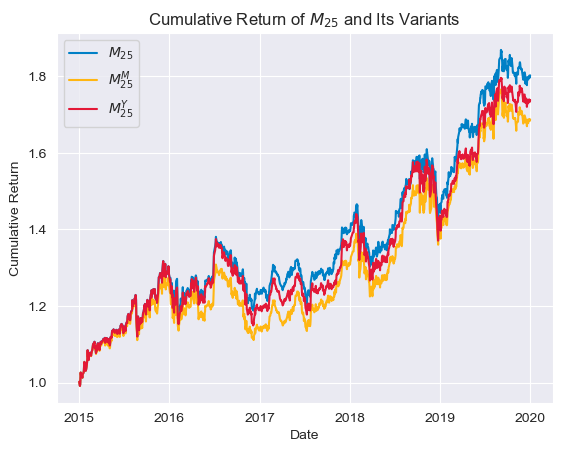

In [272]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + mu25_M_returns).cumprod(),color='#FFB612',label='$M_{25}^M$')
plt.plot((1 + mu25_Y_returns).cumprod(),color='#E31837',label='$M_{25}^Y$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $M_{25}$ and Its Variants')
plt.show()

Interestingly, we can see that most of the loss of performance for the $M_{25}^M$ happens in 2016. For $M_{25}^Y$ it is much more interesting as the loss of performance rose to be in par as in the end during 2017 but then in 2018 it got equal for the short while but then during end of 2018 and beginning of 2019 there was sudden loss of performance. Solely on this experiment I wouldn't advise to reweight the investments in this style. But maybe if we did these readjustments while only using the stocks that are currently part of the Nasdaq-100 it could an interesting investing strategy and is an area worth to be explored in the future.

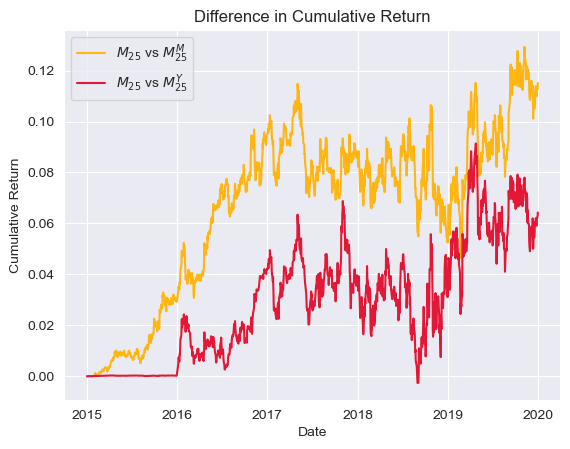

In [316]:
plt.plot(pd.DataFrame(np.array((1 + returns @ mu25_weights).cumprod()) - np.array((1 + mu25_M_returns).cumprod())[:, 0],
                      index=returns.index),label='$M_{25}$ vs $M_{25}^M$',color='#FFB612')
plt.plot(pd.DataFrame(np.array((1 + returns @ mu25_weights).cumprod()) - np.array((1 + mu25_Y_returns).cumprod())[:, 0],
                      index=returns.index),label='$M_{25}$ vs $M_{25}^Y$',color='#E31837')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Difference in Cumulative Return')
plt.show()

Now, we can start talking about how we estimated the inputs of the Markowitz approach - the mean and the covariance matrix of the stock returns. Firstly, focusing on the mean, we already noted that our estimation of the mean is sometimes very different from then derived total gains over the whole period vs the real total gains. Also, the problem here is that the metric we chose to compare the approaches, which we could argue is in reality more important than mean daily returns, is not the same to the estimating method. In the following experiment we will estimate the annual mean by the geometric mean. The resulting portfolio can be denoted as ${gM}_{25}$. This portfolio will be also focused to deliver annual gain of 25%. When calculating we even get that the expected risk should be higher but only by a small margin.

In [416]:
## Calculating the geometric mean
annual_geometric_mean_returns = []

for stock_returns in stock_returns_before2015:
    total_return = (1+stock_returns).prod()
    annual_mean_return = total_return**(1/5) - 1

    annual_geometric_mean_returns.append(annual_mean_return)

annual_geometric_mean_returns = np.array(annual_geometric_mean_returns)  # Converting into array for easier handling

In [415]:
## Calculating the weights using previously derived formulae
wanted_return = 0.25
A_ = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ np.ones(number_of_stocks)
B_ = np.ones(number_of_stocks).T @ inverse_covariance_matrix @ annual_geometric_mean_returns
C_ = annual_geometric_mean_returns.T @ inverse_covariance_matrix @ annual_geometric_mean_returns
D_ = A_*C_ - B_**2

delta_1 = (C_ - B_ * wanted_return) / D_
delta_2 = (A_ * wanted_return - B_) / D_
gmu25_weights = inverse_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_geometric_mean_returns)

Here we see the ${gM}_{25}$ which some of the other portfolios. As we would imagine it is very similar to the original ${M}_{25}$ with basically the same associated risk, but beats it with total return of almost 92% vs 80% the original, while beating also the equal weights portfolio (81%). Additionally, it also beats the original portfolio using the estimated daily means, which when annualized have the difference about 1.5%. We see that the new portfolio was better for the whole time but only by a small margin, but in the beginning of 2019 this margin suddenly increased. Overall, we believe this could be a better approach as it reflects our real goal of having the highest total gain possible with some constrains on the risk.

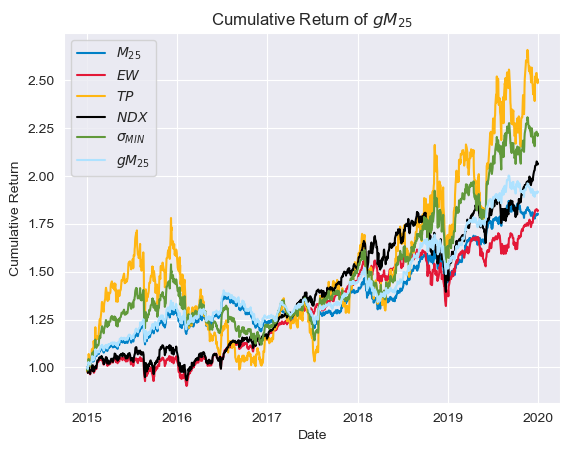

In [417]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + returns @ EW_weights).cumprod(),color='#E31837',label='$EW$')
plt.plot((1 + returns @ TP_weights).cumprod(),color='#FFB612',label='$TP$')
plt.plot((1+nasdaq_100_returns).cumprod(),color='black',label='$NDX$')
plt.plot((1 + returns @ sigma_min_weights).cumprod(),color='#61993B',label='$\sigma_{MIN}$')
plt.plot((1 + returns @ gmu25_weights).cumprod(),color='#AEE2FF',label='$gM_{25}$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $gM_{25}$')
plt.show()

The other estimated values we use are of the covariances and variances - together the covariance matrix. The covariances try to explain the relationship between two stocks and in the Markowitz model it represents a way to reduce the risk. I argue that this is not a good way to represent a relationship. Firstly, the dynamic of a relationship often changes over time, and we have estimated from 5 years of observations, so many current relationships can be underestimated and past relationships overestimated. Secondly, as we deal with daily data if one stock somewhat influence other stocks behaviour but not in same day but let's say in span of a week then we estimated the relationship as nonexistent. Also, covariance only measures linear dependence.

Knowing that we might want to either change the way the relationship is calculated or we might weaken the significance of it. We might weaken it by basically assuming that all the stocks are independent of each other. Let's denote the portfolio that is calculated as such as ${iM}_{25}$.

In [492]:
inverse_indep_covariance_matrix = np.linalg.inv(np.diag(np.diag(covariance_matrix)))

# Calculating the weights using previously derived formulae
wanted_return = 0.25
A_ = np.ones(number_of_stocks).T @ inverse_indep_covariance_matrix @ np.ones(number_of_stocks)
B_ = np.ones(number_of_stocks).T @ inverse_indep_covariance_matrix @ annual_mean_returns
C_ = annual_mean_returns.T @ inverse_indep_covariance_matrix @ annual_mean_returns
D_ = A_*C_ - B_**2
delta_1 = (C_ - B_ * wanted_return) / D_
delta_2 = (A_ * wanted_return - B_) / D_
imu25_weights = inverse_indep_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_mean_returns)

What we get is that the weights in the portfolio are all positive and most the weights are between 0.5% and 2.5%. So the portfolio is very diversified. Looking at the plot below we see that this portfolio is basically on par with equal weights portfolio and thus also beats $M_{25}$ portfolio. We wouldn't advise to use this approach.

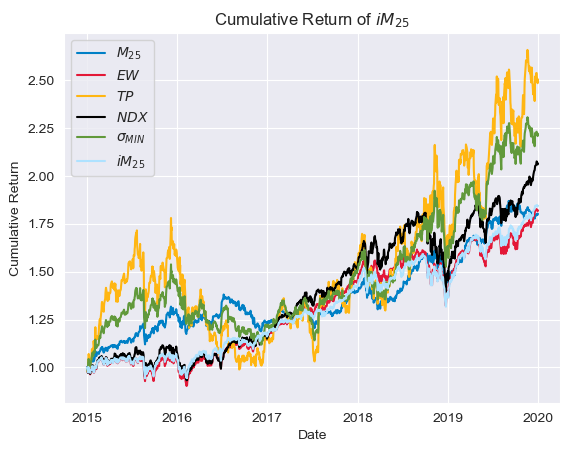

In [505]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + returns @ EW_weights).cumprod(),color='#E31837',label='$EW$')
plt.plot((1 + returns @ TP_weights).cumprod(),color='#FFB612',label='$TP$')
plt.plot((1 + nasdaq_100_returns).cumprod(),color='black',label='$NDX$')
plt.plot((1 + returns @ sigma_min_weights).cumprod(),color='#61993B',label='$\sigma_{MIN}$')
plt.plot((1 + returns @ imu25_weights).cumprod(),color='#AEE2FF',label='$iM_{25}$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $iM_{25}$')
plt.show()

Another way is not to delete the relationship but reduce it by dividing all the estimates of the covariance by 2. Let's denote it as $rM_{25}$.

In [513]:
inverse_reduced_covariance_matrix = np.linalg.inv(covariance_matrix/2 + np.diag(np.diag(covariance_matrix))/2)

# Calculating the weights using previously derived formulae
wanted_return = 0.25
A_ = np.ones(number_of_stocks).T @ inverse_reduced_covariance_matrix @ np.ones(number_of_stocks)
B_ = np.ones(number_of_stocks).T @ inverse_reduced_covariance_matrix @ annual_mean_returns
C_ = annual_mean_returns.T @ inverse_reduced_covariance_matrix @ annual_mean_returns
D_ = A_ * C_ - B_ ** 2
delta_1 = (C_ - B_ * wanted_return) / D_
delta_2 = (A_ * wanted_return - B_) / D_
rmu25_weights = inverse_reduced_covariance_matrix @ (delta_1 * np.ones(number_of_stocks) + delta_2 * annual_mean_returns)

In the graph, we observe that the portfolio is somewhat worse than $M_{25}$, but unsurprisingly the portfolios have similar trajectories. Again, based on this simple experiment, we wouldn't advise to use this approach in practise.

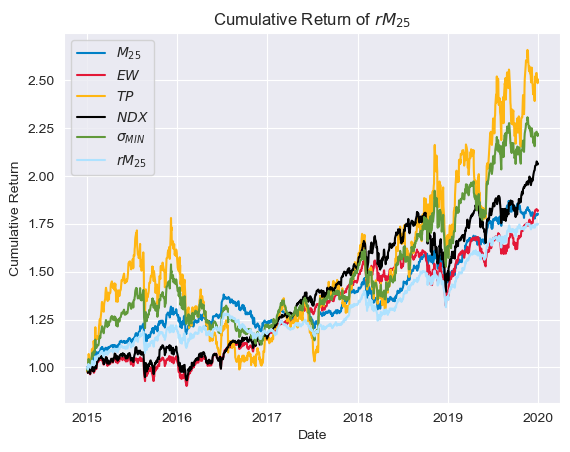

In [514]:
plt.plot((1 + returns @ mu25_weights).cumprod(),color='#0080C6',label='$M_{25}$')
plt.plot((1 + returns @ EW_weights).cumprod(),color='#E31837',label='$EW$')
plt.plot((1 + returns @ TP_weights).cumprod(),color='#FFB612',label='$TP$')
plt.plot((1 + nasdaq_100_returns).cumprod(),color='black',label='$NDX$')
plt.plot((1 + returns @ sigma_min_weights).cumprod(),color='#61993B',label='$\sigma_{MIN}$')
plt.plot((1 + returns @ rmu25_weights).cumprod(),color='#AEE2FF',label='$rM_{25}$')
plt.legend()
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.title('Cumulative Return of $rM_{25}$')
plt.show()